### Imports

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import importlib
import re
import yaml

import sklearn.ensemble 
import sklearn.model_selection
import sklearn.inspection
import sklearn.metrics

import matplotlib.pyplot as plt

import findatree.io as io
import findatree.descriptions as descriptions

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

# Dictionaries: species_name to ba and vice versa
species_id_to_name = descriptions.species_id_to_name()
species_name_to_id = descriptions.species_name_to_id()

### Definitions

In [2]:
# Directory: Plots
dir_plots = r"C:\Data\lwf\analysis\221029_random_forest\plots"

# Directory: sklearn
dirs_sklearn = [
    r"C:\Data\lwf\analysis\221029_random_forest\sklearn\v01",
]

# Save names:
load_name_params = 'params.yaml'
load_name_gridcv = 'grid.joblib'
load_name_dataset = 'dataset.joblib'
# load_name_permutation_test_score = 'permutation_test_score.joblib'
# load_name_permutation_feature_importance = 'permutation_feature_importance.joblib'

### Load

#### Load: Pre-computed dataset and sklearn results

In [3]:
datasets = []
grds = []
params = []

for dir_sklearn in dirs_sklearn:

    # Load dataset & sklearn results
    datasets.append(joblib.load(os.path.join(dir_sklearn, load_name_dataset)))
    grds.append(joblib.load(os.path.join(dir_sklearn, load_name_gridcv)))
    # permutation_test_score = joblib.load(os.path.join(dir_sklearn, load_name_permutation_test_score))
    # permutation_feature_importance = joblib.load(os.path.join(dir_sklearn, load_name_permutation_feature_importance))

    # Load params
    with open(os.path.join(dir_sklearn, load_name_params), "r") as f:
        params.append(yaml.safe_load(f))

### v01: Conifers vs. Broadleaf

#### v01: Best estimator

In [4]:
i = 0
grd = grds[i]
dataset = datasets[i]
param = params[i]

print(f"v{str(i+1).zfill(2)}: Grid Search Cross Validation: Best estimator")
print('-'*50)
print(f"{'Params:':<20}{grd.best_params_}")
print(f"{'Validation score:':<20}{grd.best_score_:.2f}")
print(f"{'Test score:':<20}{grd.best_estimator_.score(dataset['x_test'], dataset['y_test']):.2f}")
print(f"{'Shape of training features:':<20}{dataset['x_train'].shape}")


cv_results = pd.DataFrame(grd.cv_results_)
cv_results.drop(columns=['params'], inplace=True)

v01: Grid Search Cross Validation: Best estimator
--------------------------------------------------
Params:             {'criterion': 'entropy', 'max_samples': 0.75, 'min_samples_leaf': 1, 'n_estimators': 100}
Validation score:   0.94
Test score:         0.93
Shape of training features:(3021, 108)


#### v01: Confusion matrix

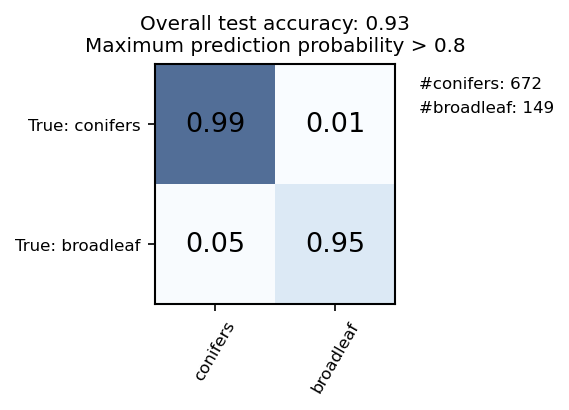

In [32]:
x = dataset['x_test'].copy()
y = dataset['y_test'].copy()

y_extend_names = dataset['y_extend_names'].copy()
y_extend = dataset['y_extend_test'].copy()

y_pred = grd.best_estimator_.predict(x)
y_pred_proba = grd.best_estimator_.predict_proba(x)

proba_thresh = 0.8
select = np.max(y_pred_proba, axis=1) > proba_thresh

y = y[select]
y_pred = y_pred[select]

confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)
confusion_matrix_norm = sklearn.metrics.confusion_matrix(y, y_pred, normalize='true')


f = plt.figure(figsize=[4,4])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.3, right=0.7)
ax = f.add_subplot(111)

ticks = range(len(confusion_matrix))

ax.imshow(
    confusion_matrix,
    cmap='Blues',
    alpha=0.7,
)

for xtick in ticks:
    for ytick in ticks:
        ax.text(ytick, xtick, f"{confusion_matrix_norm[xtick,ytick]:.2f}", ha='center', va='center', fontsize=13)
 
ax.set_title(
    f"Overall test accuracy: {grd.best_estimator_.score(dataset['x_test'], dataset['y_test']):.2f}\n" +
    f"Maximum prediction probability > {proba_thresh:.1f}"
)

ax.set_xticks(ticks)
ax.set_xticklabels([param['classes'][tick]['family_name'] for tick in ticks], rotation=60)
ax.set_yticks(ticks)
_ = ax.set_yticklabels(['True: ' + param['classes'][tick]['family_name'] for tick in ticks], rotation=0)

for class_id, class_dict in param['classes'].items():
    ax.text(
        1.7,
        -0.3 + 0.2 * class_id,
        f"#{class_dict['family_name']}: {np.sum(y==class_id)}",
    )


save_name = f"random_forest_confusion_v01_p{proba_thresh*100:.0f}" + '.pdf'
plt.savefig(os.path.join(dir_plots, save_name), transparent=True)